In [1]:
import scipy.io.wavfile as wav
import os
from python_speech_features import mfcc
from sklearn.model_selection import train_test_split
from hmmlearn.hmm import GaussianHMM
import librosa
from sklearn.preprocessing import normalize
from scipy.stats import multivariate_normal
import noisereduce as nr

C:\Users\javadpsk\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataDir = 'recordings'
numberOfClasses = 10
numberOfFilesPerClasses = 300

In [3]:
audioIndex = 0
numberOFFiles = len(os.listdir(dataDir))
audio = np.empty(numberOFFiles, dtype=object)
for fileName in os.listdir(dataDir):
    data, sr = librosa.load(os.path.join(dataDir, fileName))
    data = data[abs(data - 0) > 1e-6]
    data = nr.reduce_noise(data, sr)
    mfccVec = librosa.feature.mfcc(y=data, n_mfcc=13, sr=sr)
    audio[audioIndex] = mfccVec[:, 0:45]
    audioIndex += 1
audioIndex

3000

In [4]:
categorizedMfccVec = np.empty((numberOfClasses, numberOfFilesPerClasses), dtype=object)
for i in range(numberOfClasses):
    categorizedMfccVec[i] = audio[i*numberOfFilesPerClasses:(i+1)*numberOfFilesPerClasses]
    

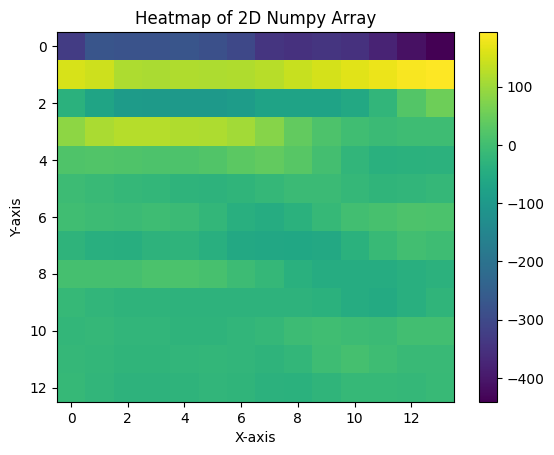

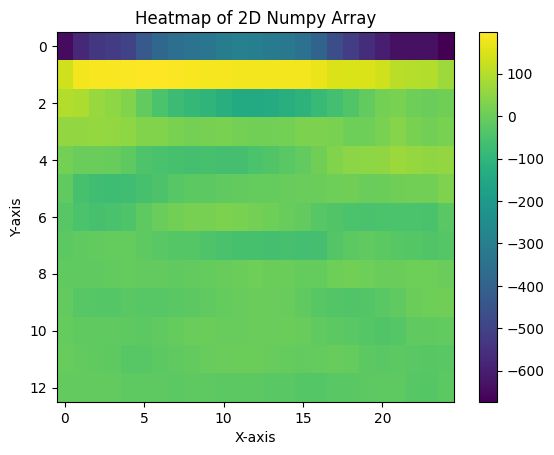

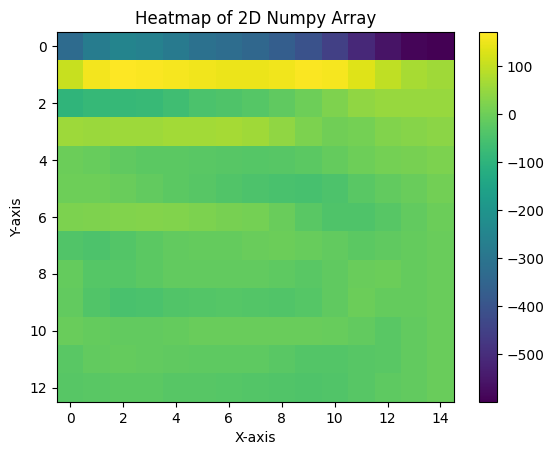

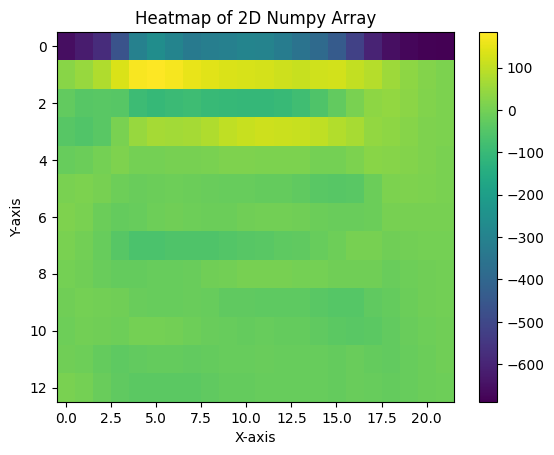

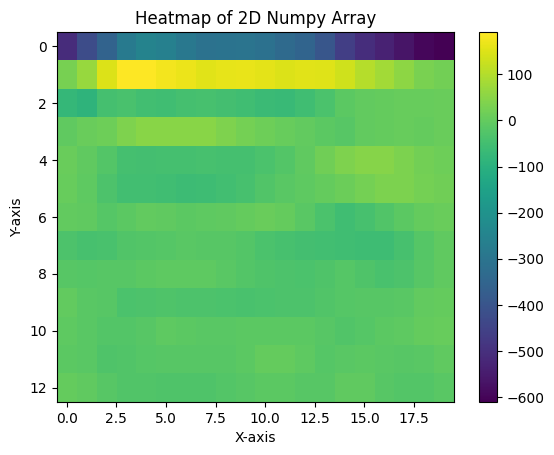

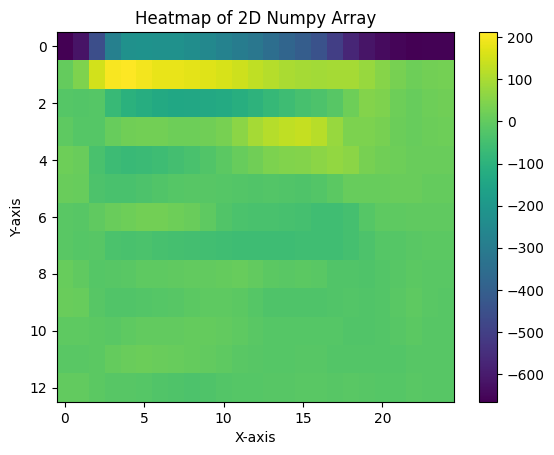

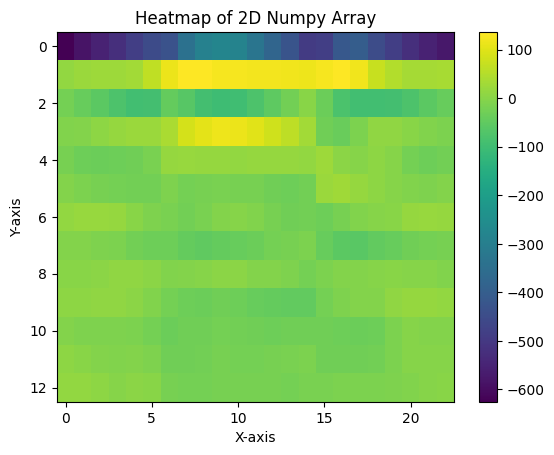

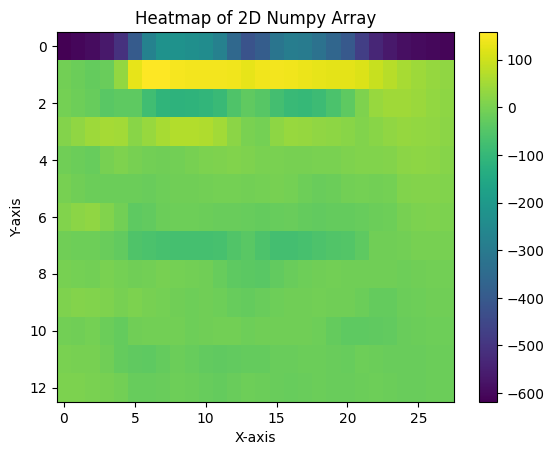

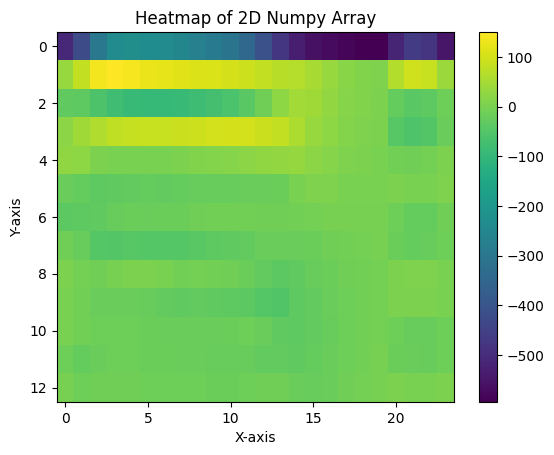

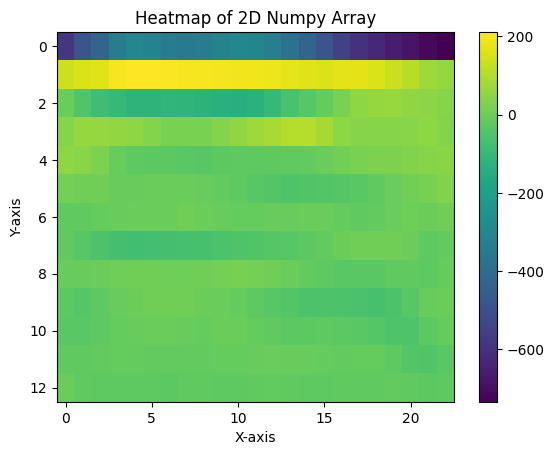

In [5]:
for i in range(numberOfClasses):
    plt.imshow(categorizedMfccVec[i][0], cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title("Heatmap of 2D Numpy Array")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()


In [6]:
trainDatas = np.empty((numberOfClasses), dtype=object)
testDatas = np.empty((numberOfClasses), dtype=object)
for i in range(numberOfClasses):
    X_train, X_test = train_test_split(categorizedMfccVec[i], test_size=0.2, random_state=42)
    trainDatas[i] = normalize(np.concatenate(X_train, axis=1), axis=0)
    testDatas[i] = [normalize(x, axis=0) for x in X_test]

In [11]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:,0] = self.initial_prob[:,t] * observation_matrix[:,t]
            else:
                alpha[:,t] = np.matmul(self.transition_matrix.T,alpha[:,t-1]) * observation_matrix[:,t]
            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] =  np.matmul(self.transition_matrix,(observation_matrix[:,t+1] * beta[:,t+1]))
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs.T,mean =self.mean[:,s],cov = self.covariances[:,:,s])

        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]
        B = self._state_likelihood(obs)
        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = np.matmul(alpha[:,t],(beta[:,t+1].T*B[:,t+1].T))*self.transition_matrix
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:,t] * beta[:,t]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:,T-1] * beta[:,T-1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = np.reshape(gamma[:, 0],(-1,1))
        expected_transition = self._stochasticize(xi_sum/np.sum(xi_sum,axis=1))

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=10):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood

In [8]:
# hmm_models = np.empty(numberOfClasses, dtype=object)
# for i in range(numberOfClasses):
#     hmm_models[i] = GaussianHMM(n_components=13)
#     hmm_models[i].fit(trainDatas[i].T)

In [12]:
hmm_prime = np.empty(numberOfClasses, dtype=object)
for i in range(numberOfClasses):
    hmm_prime[i] = HMM(num_hidden_states=13)
    hmm_prime[i].train(trainDatas[i], 10)

In [10]:
pred = []
scores = []
for testData in testDatas[1]:
    scores = []
    for i in range(numberOfClasses):
        scores.append(hmm_prime[i].score(testData))
    pred.append(np.argmax(scores))
coutn = 0
for x in pred:
    if x == 1:
        coutn+=1
print("acc = ", coutn/len(testDatas[1]))

acc =  0.7
